In [1]:
import csv
#import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import snowflake.connector
import os

In [33]:
# For the purposes of this model, the csv files needed have been assembled as follows:
# comments.csv
# SELECT ACCOUNT_NAME, count(*) as NUM_COMMENTS FROM ANALYTICS.EDW_CE.COMMUNITY_ACTIVITY WHERE CREATED_DATE BETWEEN '2022-01-01' AND '2022-12-31' GROUP BY ACCOUNT_NAME
#
# deployments.csv:
# SELECT G.SNAPSHOT_DATE, G.ORG_ID, G.ORACLE_ID, A.ACCOUNT_NAME, G.SOFTWARE_VERSION, G.MODEL_NAME, G.SKU, G.PREMISE_SUBTYPE, G.GS_30_DAYS_COUNT, G.GS_ALL_TIME_COUNT
# FROM "ANALYTICS"."EDW_CE"."GIGASPIRE_DEPLOYMENTS_HISTORICAL" G
# LEFT JOIN "ANALYTICS"."EDW_CE"."ACCOUNT" A ON ORACLE_ID = A.ACCOUNT_ORACLE_ID
# WHERE G.PREMISE_TYPE = 'GigaSpire' AND G.SNAPSHOT_DATE = '2022-12-31' AND ORACLE_ID IS NOT NULL

In [3]:
# This chunk uses the snowflake-python connector to load comments db data into a dataframe if the csv does not exist
if os.path.exists("interactions.csv"):
    print("file exists, reloading dataframe")
    df_com = pd.read_csv("interactions.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("SELECT C.*, A.ACCOUNT_ORACLE_ID FROM ANALYTICS.EDW_CE.COMMUNITY_ACTIVITY C LEFT JOIN ANALYTICS.EDW_CE.ACCOUNT A ON C.ACCOUNT_ID=A.ACCOUNT_ID WHERE CREATED_DATE BETWEEN '2022-01-01' AND '2022-12-31'")
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_com = pd.DataFrame(d, columns=cols)

    df_com.to_csv('interactions.csv')


file exists, reloading dataframe


C:\Users\nmathur\AppData\Local\Temp\ipykernel_17072\1853342237.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_com = pd.read_csv("interactions.csv")


In [4]:
# This chunk uses the snowflake-python connector to load seployments db data into a dataframe if the csv does not exist
if os.path.exists("deployments.csv"):
    print("file exists, reloading dataframe") 
    df_dep = pd.read_csv("deployments.csv")
else:
    print("Generating csv...")
    conn = snowflake.connector.connect( user='NAMAN.MATHUR@CALIX.COM',
                                        authenticator='externalbrowser',
                                        account='calix',
                                        database='ANALYTICS',
                                        warehouse='USER_WH',
                                        role="DBT_DEVELOPER",
                                        schema='EDW_CE',)
    cur = conn.cursor()
    cur.execute("SELECT G.SNAPSHOT_DATE, G.ORG_ID, G.ORACLE_ID, A.ACCOUNT_NAME, G.SOFTWARE_VERSION, G.MODEL_NAME, G.SKU, G.PREMISE_TYPE, G.PREMISE_SUBTYPE, G.GS_30_DAYS_COUNT, G.GS_ALL_TIME_COUNT FROM ANALYTICS.EDW_CE.GIGASPIRE_DEPLOYMENTS_HISTORICAL G LEFT JOIN ANALYTICS.EDW_CE.ACCOUNT A ON ORACLE_ID = A.ACCOUNT_ORACLE_ID WHERE G.PREMISE_TYPE in ('GigaSpire','GigaSpire - DTM') AND G.SNAPSHOT_DATE = '2022-12-31' AND ORACLE_ID IS NOT NULL")
    d = cur.fetchall()
    cols = [] 
    for i in cur.description:
        cols.append(i[0])
    df_dep = pd.DataFrame(d, columns=cols)

    df_dep.to_csv('deployments.csv')

Generating csv...


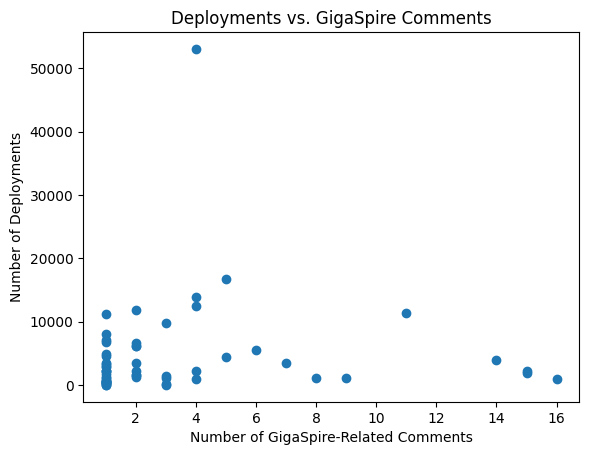

In [22]:
# Visualization

# roles = ["Manager", "Specialist", 'Engineer', 'Technician']
# functions = ["Marketing", "Sales", 'Operations']

# for role in roles:
#     for function in functions:

#         dep_agg = df_dep.groupby(by=['ORACLE_ID']).GS_ALL_TIME_COUNT.sum().reset_index()
#         com_agg = df_com.groupby(by=['ACCOUNT_ORACLE_ID', 'LEVEL', 'FUNCTION']).count().reset_index()[['ACCOUNT_ORACLE_ID', 'ID', 'LEVEL', "FUNCTION"]]
#         com_agg = com_agg.query("LEVEL=='"+role+"' & FUNCTION=='"+function+"'")

#         #dep_agg.head()
#         #com_agg.head()

#         total = pd.merge(dep_agg, com_agg, left_on='ORACLE_ID', right_on='ACCOUNT_ORACLE_ID')
#         # total.head()

#         # # total.to_csv("managers_comments_deployments_total_merged.csv")
#         plt.clf()
#         plt.scatter(total["ID"], total["GS_ALL_TIME_COUNT"])
#         plt.xlabel("Number of "+function+" "+role+" Comments")
#         plt.ylabel("Number of Deployments")
#         plt.title("Deployments vs. "+function+" "+role+" Comments")
#         plt.savefig("Deployments_vs._"+function+"_"+role+"_Comments.png")

#names = pd.Series(["GigaSpire", "Gigaspire", "GigaCenter", "Gigecenter", "Gigaspre", "Gigafamily", "GigaGamily", "Giga Spire", "GIgaSpire"])
df_topic = df_com[df_com['TOPIC_NAME'].str.contains("GigaSpire|Gigaspire|GigaCenter|Gigecenter|Gigaspre|Gigafamily|GigaGamily|Giga Spire|GIgaSpire")]
df_comments = df_topic[df_topic['ENTITY_TYPE'].str.contains("Comment")]

dep_agg = df_dep.groupby(by=['ORACLE_ID']).GS_ALL_TIME_COUNT.sum().reset_index()
com_agg = df_comments.groupby(by=['ACCOUNT_ORACLE_ID']).count().reset_index()[['ACCOUNT_ORACLE_ID', 'ID']]
#dep_agg.head()
#com_agg.head()

total = pd.merge(dep_agg, com_agg, left_on='ORACLE_ID', right_on='ACCOUNT_ORACLE_ID')
# total.head()

# # total.to_csv("managers_comments_deployments_total_merged.csv")
plt.clf()
plt.scatter(total["ID"], total["GS_ALL_TIME_COUNT"])
plt.xlabel("Number of GigaSpire-Related Comments")
plt.ylabel("Number of Deployments")
plt.title("Deployments vs. GigaSpire Comments")
plt.savefig("Deployments_vs._GigaSpire_Comments.png")

